# Motor Vehicle Accident XML Check Part 2

This notebook checks the integrity of the periodic Motor Vehicle Accident (MVA) report XML files we receive into `\\tssrv7\CollisionsProcessed\AtSceneXmlBackups`, reflecting the fact that we now have access to a mirror of the Oracle database.

In [141]:
%matplotlib inline

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import configparser
import pathlib
import psycopg2
import psycopg2.extras as ppg2extras
import cx_Oracle
import re

# Default mpl colours.
prop_cycle = plt.rcParams['axes.prop_cycle']
mpl_def_colors = prop_cycle.by_key()['color']

In [2]:
config = configparser.ConfigParser()
config.read(pathlib.Path.home().joinpath('.charlesconfig').as_posix());
postgres_settings = config['POSTGRES']
oracle_settings = config['ORACLE']

## Load XML Filenames

In [13]:
rootfolder = '/mnt/ldrive/AtSceneXmlBackups/'
xml_folders = os.listdir(rootfolder)
filenames = {fn: os.listdir(rootfolder + fn) for fn in xml_folders}

In [14]:
def get_name_info(filename, filepath):
    accyear_str, go_number_str = re.split("_|-", filename[:-4])[-2:]
    try:
        go_number = int(go_number_str)
    except Exception:
        raise ValueError("{0} was converted to {1}, which can't be "
                         "converted to an integer."
                         .format(mystr, go_number))

    try:
        accyear = int(accyear_str[2:])
        assert (accyear // 1000 > 1), ""
    except Exception as exc:
        raise ValueError("{0} was converted to {1}, which can't be "
                         "converted to an integer. Error raised:"
                         .format(mystr, accyear, str(exc)))

    acc_number = 1000000000 * int(accyear_str[-1]) + go_number
    
    return {'fullpath': filepath + "/" + filename,
            'filename': filename,
            'accyear': accyear,
            'go_number': go_number,
            'acc_number': acc_number}

coln_xml_r = [get_name_info(x, fn_key)
              for fn_key in filenames.keys() for x in filenames[fn_key]
              if x[-4:] == '.xml']
coln_xml_r = pd.DataFrame(coln_xml_r)

In [15]:
coln_xml_r_unique = coln_xml_r.groupby(
    ['filename', 'accyear', 'go_number', 'acc_number'])['fullpath'].count()
dups = coln_xml_r_unique[coln_xml_r_unique > 1]
dups = dups.reset_index()['acc_number'].unique()

coln_xml = coln_xml_r[['accyear', 'go_number', 'acc_number']].drop_duplicates()
coln_xml.reset_index(drop=True, inplace=True)

In [16]:
coln_xml_20152019 = coln_xml.loc[(coln_xml['accyear'] >= 2014) & (coln_xml['accyear'] < 2020), :].copy()

In [17]:
coln_xml_20152019

,accyear,go_number,acc_number
1537,2014,1008236,4001008236
1538,2014,1057534,4001057534
1539,2014,1059448,4001059448
1540,2014,10667333,4010667333
1541,2014,1071106,4001071106
...,...,...,...
93414,2019,651058,9000651058
93415,2019,798958,9000798958
93576,2019,212276,9000212276
93638,2019,1961849,9001961849


## Load ACC Numbers from Oracle

In [18]:
sql_query = """SELECT ACCNB,
       EXTRACT(YEAR FROM ACCDATE) ACCYEAR,
       ACCDATE,
       CASE
         WHEN ACCNB >= 1000000000 THEN 'TPS'
         WHEN ACCNB >= 100000000 THEN 'CRC'
         ELSE 'DUNNO'
       END data_source
FROM TRAFFIC.ACC
WHERE accdate BETWEEN TO_DATE('2014-01-01', 'YYYY-MM-DD') AND TO_DATE('2019-12-31', 'YYYY-MM-DD')
GROUP BY ACCNB, ACCDATE"""

with cx_Oracle.connect(oracle_settings['user'], oracle_settings['password'],
                       "{host}:{port}/{service_name}".format(**oracle_settings),
                       encoding="UTF-8") as conn:
    df_acc = pd.read_sql(sql_query, con=conn)

In [19]:
sql_query = """SELECT ACCNB,
       EXTRACT(YEAR FROM ACCDATE) ACCYEAR,
       ACCDATE,
       CASE
         WHEN ACCNB >= 1000000000 THEN 'TPS'
         WHEN ACCNB >= 100000000 THEN 'CRC'
         ELSE 'DUNNO'
       END data_source
FROM TRAFFIC.ACC_ARCHIVE
WHERE accdate BETWEEN TO_DATE('2014-01-01', 'YYYY-MM-DD') AND TO_DATE('2019-12-31', 'YYYY-MM-DD')
GROUP BY ACCNB, ACCDATE"""

with cx_Oracle.connect(oracle_settings['user'], oracle_settings['password'],
                       "{host}:{port}/{service_name}".format(**oracle_settings),
                       encoding="UTF-8") as conn:
    df_accarchive = pd.read_sql(sql_query, con=conn)

In [20]:
df_acc.shape

(343242, 4)

In [21]:
df_accarchive.shape

(37801, 4)

In [23]:
df_acc['TABLE'] = 'ACC'
df_accarchive['TABLE'] = 'ACC_ARCHIVE'

In [36]:
df_oracle = pd.concat([df_acc, df_accarchive])
df_oracle.reset_index(inplace=True, drop=True)
df_oracle.columns = ['accnb', 'accyear', 'accdate', 'data_source', 'table']

In [37]:
df_oracle.groupby(['data_source', 'table'])['accnb'].count()

data_source  table      
CRC          ACC            271303
             ACC_ARCHIVE     29015
DUNNO        ACC                84
             ACC_ARCHIVE         3
TPS          ACC             71855
             ACC_ARCHIVE      8783
Name: accnb, dtype: int64

There's apparently 6 ACCNBs that start with 0. This is the source of a few of our `DUNNO`s.

In [41]:
df_oracle.loc[df_oracle['accnb'].str.startswith('0'), :]

,accnb,accyear,accdate,data_source,table
0,0000267847,2019,2019-12-31,DUNNO,ACC
86113,0000599104,2019,2019-11-30,DUNNO,ACC
193132,0000916740,2017,2017-05-17,DUNNO,ACC
361151,0000041926,2019,2019-12-22,DUNNO,ACC_ARCHIVE
371540,0000759795,2019,2019-12-09,DUNNO,ACC_ARCHIVE
375366,0000036048,2019,2019-12-26,DUNNO,ACC_ARCHIVE


In [43]:
df_oracle['accnb'] = df_oracle['accnb'].astype(int)

## Merge Datasets for Comparison

In [44]:
df_merge = pd.merge(coln_xml_20152019, df_oracle, how='outer',
                    left_on='acc_number', right_on='accnb',
                    suffixes=('_xml', '_oracle'))

In [45]:
df_merge

,accyear_xml,go_number,acc_number,accnb,accyear_oracle,accdate,data_source,table
0,2014.0,1008236.0,4.001008e+09,NaN,NaN,NaT,NaN,NaN
1,2014.0,1057534.0,4.001058e+09,4.001058e+09,2014.0,2014-02-05,TPS,ACC
2,2014.0,1059448.0,4.001059e+09,4.001059e+09,2014.0,2014-02-19,TPS,ACC
3,2014.0,10667333.0,4.010667e+09,4.010667e+09,2014.0,2014-03-09,TPS,ACC
4,2014.0,1071106.0,4.001071e+09,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...
381489,NaN,NaN,NaN,1.880275e+08,2018.0,2018-05-29,CRC,ACC_ARCHIVE
381490,NaN,NaN,NaN,1.680237e+08,2016.0,2016-06-08,CRC,ACC_ARCHIVE
381491,NaN,NaN,NaN,1.680239e+08,2016.0,2016-06-05,CRC,ACC_ARCHIVE
381492,NaN,NaN,NaN,1.880233e+08,2018.0,2018-05-05,CRC,ACC_ARCHIVE


## Analysis

In [61]:
df_merge.loc[df_merge['accyear_xml'].isna(), 'data_source'].value_counts(dropna=False)

CRC      300318
TPS         262
DUNNO        87
Name: data_source, dtype: int64

In [48]:
# No NaNs, so we can run a multi-index value count.
df_merge.loc[df_merge['accyear_xml'].isna(), ['data_source', 'table']].value_counts()

data_source  table      
CRC          ACC            271303
             ACC_ARCHIVE     29015
TPS          ACC               245
DUNNO        ACC                84
TPS          ACC_ARCHIVE        17
DUNNO        ACC_ARCHIVE         3
dtype: int64

So the `CRC` and `DUNNO` columns are to be expected. As before, there are also 245 TPS collisions unaccounted for in `ACC`, and an additional 17 in `ACC_ARCHIVE`.

In [50]:
(df_merge.loc[df_merge['accyear_xml'].isna() & (df_merge['data_source'] == 'TPS'), :]
 .groupby('accyear_oracle')['accyear_oracle'].count())

accyear_oracle
2014.0    15
2015.0    14
2016.0    53
2017.0    60
2018.0    63
2019.0    57
Name: accyear_oracle, dtype: int64

Some argument to be made that the number of unaccounted collisions increased substantially starting in 2016, but inconclusive.

In [51]:
(df_merge.loc[(df_merge['data_source'] == 'DUNNO'), :]
 .groupby('accyear_oracle')['accyear_oracle'].count())

accyear_oracle
2016.0    24
2017.0    16
2018.0    12
2019.0    35
Name: accyear_oracle, dtype: int64

This is identical to what we found before (except for the 3 extra collisions from `ACC_ARCHIVE` in 2019). From our previous investigation they're not found in the XML records, so are more likely improperly loaded CRC, or generated by the mail clerks.

In [55]:
df_merge.loc[~df_merge['accyear_xml'].isna(), 'data_source'].value_counts(dropna=False)

TPS    80376
NaN      451
Name: data_source, dtype: int64

In [56]:
df_merge.loc[~df_merge['accyear_xml'].isna(), 'table'].value_counts(dropna=False)

ACC            71610
ACC_ARCHIVE     8766
NaN              451
Name: table, dtype: int64

This is an excellent sign - the vast majority of the missing collisions in our original study can be found in `ACC_ARCHIVE` because they were deemed to be on private property by the ACC loader. Exactly *why* they were deemed to be on private property remains a mystery (we'll explore this below).

For now, let's focus on the `NaN`s.

In [57]:
# Get all ACC numbers missing from Oracle.
missing_acc = df_merge.loc[(df_merge['data_source'].isna()), 'acc_number'].astype(int).values

In [62]:
coln_missing_acc = (
    coln_xml_r.loc[coln_xml_r['acc_number'].isin(missing_acc), :]
    .groupby(['filename', 'accyear', 'go_number', 'acc_number'])['fullpath']
    .min()).reset_index()

In [69]:
import xml.etree.ElementTree as et

def extract_accloc(xtree):
    accloc_node = (xtree.getroot().getchildren()[0]
                   .find('ACCIDENT').getchildren()[0]
                   .getchildren()[0].find('AccidentLocation-Box-1'))

    if accloc_node is None:
        raise ValueError('could not find AccidentLocation-Box-1!')

    try:
        return int(accloc_node.text)
    except Exception:
        return -1


def extract_occ_yr(xtree):
    occyr_node = (xtree.getroot().getchildren()[0]
                   .find('OCC_YR'))

    if occyr_node is None:
        raise ValueError('could not find OCC_YR!')

    try:
        return int(occyr_node.text)
    except Exception:
        return -1


def extract_xml_row_short(filepath):
    xtree = et.parse(filepath)
    return {'filepath': filepath,
            'accloc': extract_accloc(xtree),
            'occ_yr': extract_occ_yr(xtree)}

In [70]:
%%time
row_dicts = []
for i, row in coln_missing_acc.iterrows():
    row_dicts.append(extract_xml_row_short(rootfolder + row['fullpath']))

cma_xmlinfo = pd.DataFrame(row_dicts, index=coln_missing_acc.index)

CPU times: user 750 ms, sys: 2.36 s, total: 3.11 s
Wall time: 44.3 s


In [71]:
cma_xmlinfo['accloc'].value_counts()

 1     152
 10     87
 3      61
 2      51
-1      36
 99     31
 4      28
 98      2
 8       1
 7       1
 5       1
Name: accloc, dtype: int64

The plurality of locations are "Non Intersection", rather than on private property.

Is there a good rule of thumb for what ends up in `ACC_ARCHIVE` and what doesn't?

In [96]:
sql_query = """SELECT PRIVATE_PROPERTY, ACCLOC, LOCCOORD, COUNT(DISTINCT ACCNB) n_events
FROM TRAFFIC.ACC
WHERE "ACCDATE" BETWEEN TO_DATE('2014-01-01', 'YYYY-MM-DD') AND TO_DATE('2019-12-31', 'YYYY-MM-DD')
GROUP BY PRIVATE_PROPERTY, ACCLOC, LOCCOORD
ORDER BY 1, 2, 3"""

with cx_Oracle.connect(oracle_settings['user'], oracle_settings['password'],
                       "{host}:{port}/{service_name}".format(**oracle_settings),
                       encoding="UTF-8") as conn:
    df_acc_coordbreakdown = pd.read_sql(sql_query, con=conn)

In [98]:
sql_query = """SELECT PRIVATE_PROPERTY, ACCLOC, LOCCOORD, COUNT(DISTINCT ACCNB) n_events
FROM TRAFFIC.ACC_archive
WHERE "ACCDATE" BETWEEN TO_DATE('2014-01-01', 'YYYY-MM-DD') AND TO_DATE('2019-12-31', 'YYYY-MM-DD')
GROUP BY PRIVATE_PROPERTY, ACCLOC, LOCCOORD
ORDER BY 1, 2, 3"""

with cx_Oracle.connect(oracle_settings['user'], oracle_settings['password'],
                       "{host}:{port}/{service_name}".format(**oracle_settings),
                       encoding="UTF-8") as conn:
    df_accarchive_coordbreakdown = pd.read_sql(sql_query, con=conn)

Surely the `PRIVATE_PROPERTY` column is a good first place to start!

In [100]:
df_acc_coordbreakdown.groupby("PRIVATE_PROPERTY")['N_EVENTS'].sum()

PRIVATE_PROPERTY
N    285853
Y      1809
Name: N_EVENTS, dtype: int64

In [101]:
df_accarchive_coordbreakdown.groupby("PRIVATE_PROPERTY")['N_EVENTS'].sum()

PRIVATE_PROPERTY
N    15805
Y    21424
Name: N_EVENTS, dtype: int64

Surprisingly no! As expected, most collisions in `ACC_ARCHIVE` are on private property, and most collisions that are in `ACC` are not, but there are exceptions, and there are enough exceptions in `ACC_ARCHIVE` that I don't believe all of them fall outside the city boundaries.

In [102]:
df_acc_coordbreakdown.groupby("ACCLOC")['N_EVENTS'].sum()

ACCLOC
00        75
01    237869
02     40220
03     49066
04     14863
05       118
06        89
07       140
08        35
09       100
97        95
98       137
99       161
Name: N_EVENTS, dtype: int64

In [103]:
df_accarchive_coordbreakdown.groupby("ACCLOC")['N_EVENTS'].sum()

ACCLOC
00       10
01      258
02       57
03       31
04     1396
05        2
06        9
07        2
08       27
09       11
10    34911
98       58
99     1044
Name: N_EVENTS, dtype: int64

Likewise we definitely see more class 4, 10 and 99 `ACCLOC` in `ACC_ARCHIVE` than in `ACC`, but it's not exclusive. I can only conclude that there's a combination of several factors that divert collisions into the archive.

We can perform a more thorough check of `ACC_ARCHIVE` in an attempt to separate out collisions inside and outside of Toronto:

In [250]:
sql_query = """SELECT DISTINCT ACCNB, PRIVATE_PROPERTY, ACCLOC, LONGITUDE + 0.00021 lon, LATITUDE + 0.000045 lat
FROM TRAFFIC.ACC_ARCHIVE
WHERE "ACCDATE" BETWEEN TO_DATE('2014-01-01', 'YYYY-MM-DD') AND TO_DATE('2019-12-31', 'YYYY-MM-DD')"""

with cx_Oracle.connect(oracle_settings['user'], oracle_settings['password'],
                       "{host}:{port}/{service_name}".format(**oracle_settings),
                       encoding="UTF-8") as conn:
    df_accarchive_city = pd.read_sql(sql_query, con=conn)

df_accarchive_city = gpd.GeoDataFrame(
    df_accarchive_city, geometry=gpd.points_from_xy(df_accarchive_city.LON, df_accarchive_city.LAT))

Irritatingly, neither the CITY nor lon-lat coordinates are error-free measures of location. The city names can get really hairy.

In [251]:
sql_query = """SELECT area_name, ST_TRANSFORM(ST_BUFFER(ST_TRANSFORM(geom, 2952), 30), 4326) geom FROM gis.tor_boundary;"""

with psycopg2.connect(**postgres_settings) as db_con:
    df_torboundary = gpd.read_postgis(sql_query, db_con)

In [252]:
df_boundcheck = gpd.sjoin(df_accarchive_city.loc[(df_accarchive_city['LON'] < -10.)
                                                 & (df_accarchive_city['LAT'] > 43.), :],
                          df_torboundary,
                          how='left', op='intersects')                          

/home/czhu/pythonenv/bditto/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [253]:
# This is nonsense - CITY is the city which the involved resides in.
# def city_in_toronto(item):
#     return ((fuzz.ratio("TORONTO", item) > 75)
#             | (fuzz.partial_ratio("SCARBOROUGH", item) > 85)
#             | (fuzz.ratio("ETOBICOKE", item) > 65)
#             | (fuzz.partial_ratio("YORK", item) > 85))

# df_boundcheck['CITY_IN_TO'] = df_boundcheck['CITY'].apply(city_in_toronto)

In [255]:
df_boundcheck.loc[~df_boundcheck['area_name'].isna(), 'ACCLOC'].value_counts(dropna=False)

10     25733
04      1362
99      1016
01       221
98        56
02        55
03        28
08        25
09        11
00        10
NaN       10
06         9
07         2
05         2
Name: ACCLOC, dtype: int64

In [260]:
df_boundcheck.loc[df_boundcheck['area_name'].isna(), 'ACCLOC'].value_counts(dropna=False)

10    8970
04       4
01       1
99       1
Name: ACCLOC, dtype: int64

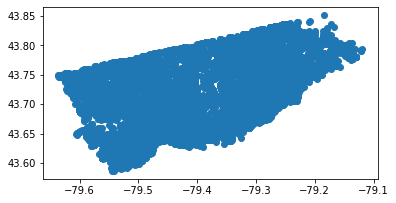

In [257]:
df_boundcheck.loc[~df_boundcheck['area_name'].isna(), :].plot()

So, we've found that it's the collisions that are geographically **WITHIN** Toronto that have a whole bunch of different `ACCLOC` codes, while the collisions that are beyond the bounds of Toronto are almost all on private property!

Create some summary statistics.

In [72]:
coln_missing_acc = pd.concat([coln_missing_acc, cma_xmlinfo], axis=1)

In [74]:
df_fulldata = pd.merge(df_merge, coln_missing_acc[['acc_number', 'accloc', 'occ_yr']],
                       how='left', left_on='acc_number', right_on='acc_number')

In [76]:
assert np.all(df_fulldata.loc[~df_fulldata['occ_yr'].isna(), 'accyear_xml']
               == df_fulldata.loc[~df_fulldata['occ_yr'].isna(), 'occ_yr']), (
    "XML filenames and occurrence year entries do not match!")

In [77]:
# df_fulldata.to_hdf('./20210505_mva_check_temp.hdf5', 'table')
# df = pd.read_hdf('./20210505_mva_check_temp.hdf5', 'table')
# assert df.equals(df_fulldata)
# df_fulldata = df

/home/czhu/pythonenv/bditto/lib/python3.6/site-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['data_source', 'table'], dtype='object')]

  encoding=encoding,


In [85]:
all_xml_events = (df_fulldata.loc[~df_fulldata['accyear_xml'].isna(), :]
                  .groupby("accyear_xml")['accyear_xml'].count())
all_tps_ocl_events = (df_fulldata.loc[df_fulldata['data_source'] == 'TPS', :]
                      .groupby("accyear_oracle")['accnb'].count())
xml_events_not_in_ocl = (
    df_fulldata.loc[~df_fulldata['accyear_xml'].isna()
                    & df_fulldata['accnb'].isna(), :].groupby("accyear_xml")['accyear_xml'].count())
# Unlike with the first MVA check, there are 60k class 10 events in ACC_ARCHIVE, so we need to
# include df_fulldata['accnb'].isna().
xml_class10_events_not_in_ocl = (
    df_fulldata.loc[~df_fulldata['accyear_xml'].isna()
                    & df_fulldata['accnb'].isna()
                    & (df_fulldata['accloc'] == 10.), :].groupby("accyear_xml")['accyear_xml'].count())
xml_nonclass10_events_not_in_ocl = (
    df_fulldata.loc[~df_fulldata['accyear_xml'].isna()
                    & df_fulldata['accnb'].isna()
                    & (df_fulldata['accloc'] != 10.), :].groupby("accyear_xml")['accyear_xml'].count())
xml_public_events_not_in_ocl = (
    df_fulldata.loc[~df_fulldata['accyear_xml'].isna()
                    & df_fulldata['accnb'].isna()
                    & ~df_fulldata['accloc'].isin([4., 10., 98., 99.]), :].groupby("accyear_xml")['accyear_xml'].count())
ocl_tps_events_not_in_xml = (
    df_fulldata.loc[df_fulldata['accyear_xml'].isna()
                    & ~df_fulldata['accnb'].isna()
                    & (df_fulldata['data_source'] == 'TPS'), :].groupby("accyear_oracle")['accnb'].count())
ocl_dunno_events_not_in_xml = (
    df_fulldata.loc[df_fulldata['accyear_xml'].isna()
                    & ~df_fulldata['accnb'].isna()
                    & (df_fulldata['data_source'] == 'DUNNO'), :].groupby("accyear_oracle")['accnb'].count())

In [86]:
df_summary = pd.concat([all_xml_events,
                        all_tps_ocl_events,
                        xml_events_not_in_ocl,
                        xml_class10_events_not_in_ocl,
                        xml_nonclass10_events_not_in_ocl,
                        xml_public_events_not_in_ocl,
                        ocl_tps_events_not_in_xml,
                        ocl_dunno_events_not_in_xml], axis=1).fillna(0.)

df_summary.columns = [
    'all_xml',
    'all_tps_ocl',
    'xml_not_in_ocl',
    'xml_class10_not_in_ocl',
    'xml_nonclass10_not_in_ocl',
    'xml_public_not_in_ocl',
    'ocl_tps_not_in_xml',
    'ocl_dunno_not_in_xml'
]

df_summary

,all_xml,all_tps_ocl,xml_not_in_ocl,xml_class10_not_in_ocl,xml_nonclass10_not_in_ocl,xml_public_not_in_ocl,ocl_tps_not_in_xml,ocl_dunno_not_in_xml
2014.0,18540,18459,112,11,101,93,15,0.0
2015.0,16563,16533,42,8,34,27,14,0.0
2016.0,13063,13036,73,12,61,46,53,24.0
2017.0,11342,11305,98,26,72,55,60,16.0
2018.0,10956,10961,55,14,41,37,63,12.0
2019.0,10363,10344,71,16,55,45,57,35.0


In [95]:
df_summary.sum(axis=0)

all_xml                      80827.0
all_tps_ocl                  80638.0
xml_not_in_ocl                 451.0
xml_class10_not_in_ocl          87.0
xml_nonclass10_not_in_ocl      364.0
xml_public_not_in_ocl          303.0
ocl_tps_not_in_xml             262.0
ocl_dunno_not_in_xml            87.0
dtype: float64

Observations :
- The difference between the XML dump and combined tables from Oracle is much narrower than before - there are 451 event records in the XMLs that aren't in Oracle, and 262 records in the Oracle that aren't in the XMLs (with an additional 87 unknown collisions that don't seem to correspond to anything). This confirms that the large number of `ACCLOC = 10` collisions missing from `ACC` are instead being inserted into `ACC_ARCHIVE`.
- Of the collisions exclusive to the XML files, a plurality of them are "Non Intersection", rather than on private property. These could potentially be outside the bounds of the City, but then they should also be in `ACC_ARCHIVE`.
- We expect the collisions in `ACC_ARCHIVE` to be either on private property or beyond the boundaries of Toronto. The investigation above shows that is indeed the case - the majority of collisions in `ACC_ARCHIVE` are class 4, 10 or 99, all of which are related to private property, but about 1% of them are not - this translates to around 400 collisions on public land, almost all of which have lon-lats. If we check these lon-lats, almost all of the 400 collisions on public land are *within* the bounds of Toronto, while those beyond are almost all on private property. So clearly there's either more information I'm not considering or there's a failure in whatever process divides collisions between `ACC` and `ACC_ARCHIVE`.

### Postscript

I just realized I didn't account for the occasional case where two collisions will have the same `ACCNB` in the same year, but on different dates. I don't know if these are improperly coded, manual editing errors or something else.